### Single-qubit Classifier

In [14]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

##### Data Setting

In [15]:
# Setting a random seed for reproducing
np.random.seed(32)

# Making a traing dataset of points inside and outside of a circle
def Circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    samples : the number of data points we will make
    center : center of the circle    
    radius : radius of the circle
    
    Retrun
    data points & labels(In - 0/Out - 1)
    """
    points= []
    labels = []

    for i in range(samples):
        
        # Mading sample points
        point = 2*np.random.rand(2)-1
        label = 0

        # Changing label to 1 if it is out of the circle
        if np.linalg.norm(point - center) > radius:
            label = 1
        
        # Collecting the sample points
        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False)

#Xpoints, Ylabels = Circle(10)
#print(Xpoints)
#print(Ylabels)

In [16]:
# Plotting the data with figuration
def plot_data(x, y, fig = None, ax = None, center = (0,0), radius = np.sqrt(2 / np.pi)):
    """
    Plotting the data with the binary classification

    data_points : data_points that will be plotted on the graph
    data_labels : which classify the points with different colors

    Return
    plot graph
    """
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    # Giving color for each point
    red = y == 0
    blue = y == 1

    draw_circle = plt.Circle(center, radius, fill=False )
    ax.scatter(x[red,0],x[red,1], c = "red", s = 10)
    ax.scatter(x[blue,0],x[blue,1], c = "blue", s = 10)
    ax.add_artist(draw_circle)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

#fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#plot_data(Xpoints, Ylabels, fig = fig, ax = ax)

In [17]:
# Defining labels to a quantum state
def quantum_label(state):
    """
    Calculates the density matrix representation of a state.

    state : array representing a quantum state vector

    Returns
    Obsevables
    """
    return state * np.conj(state).T

label_0 = [[1], [0]] # quantum labels for red points
label_1 = [[0], [1]] # quantum labels for blue points
state_labels = np.array([label_0, label_1], requires_grad=False)
dm_labels = [quantum_label(s) for s in state_labels]
print(dm_labels)

[tensor([[1, 0],
        [0, 0]], requires_grad=False), tensor([[0, 0],
        [0, 1]], requires_grad=False)]


#### Single-Qubit classifier circuits with state vector

In [18]:
# Install any pennylane-plugin to run on some particular backend
# Single qubit (wires = 1)
dev = qml.device('lightning.qubit', wires = 1)

# Designing the quantum circuit
@qml.qnode(dev)
def origin_sqc(params, x, y):
    """
    Variational Quantum Circuit for Universal Quantum Classifier
    Fig1.(a) Original Scheme

    params : array of parmaters
    x : Datas where we have to input
    y : Expected ouput density matrix

    Returns
    Expectation value
    """

    # Embedding the datas
    for p in params:
        qml.Rot(*x, wires = 0)
        qml.Rot(*p, wires = 0)
    
    # Calculating the expectation value of the supplied observable
    return qml.expval(qml.Hermitian(y, wires = [0]))

In [19]:
# Install any pennylane-plugin to run on some particular backend
# Single qubit (wires = 1)
dev = qml.device('lightning.qubit', wires = 1)

# Designing the quantum circuit
@qml.qnode(dev)
def compressed_sqc(thetas, weights, x, y):
    """
    Variational Quantum Circuit for Universal Quantum Classifier
    Fig1.(b) Compressed Scheme

    theta : array of theta...bias (theta_1, theta_2, theta_3)
    weight : array of wegiht...weight (w_1, w_2, w_3)
    x : Datas where we have to input (x_1, x_2, 0)
    y : Expected ouput density matrix

    Returns
    Expectation value
    """
    params = []
    for i in range(len(thetas)):
        params.append(thetas[i]+weights[i]*x)

    # Embedding the datas to the gate
    for p in params:
        qml.Rot(*p, wires = 0)
    
    # Calculating the expectation value of the supplied observable
    return qml.expval(qml.Hermitian(y, wires = 0))

##### Cost function with state vector

In [20]:
def cost_fc(params, x, y, state_labels=None):
    """
    Cost function to be minimized.(Fidelity cost function)
    
    params : array of parameters
    x : array of data points
    y : array of true labels
    state_labels : array of state representations for labels

    Returns
    loss value to be minimized from fidelity cost function
    """
    loss = 0.0

    # Making the representation of the labels
    dm_labels = [quantum_label(s) for s in state_labels]
    
    # Computing prediction for each input in data batch
    for i in range(len(x)):
        f = origin_sqc(params, x[i], dm_labels[y[i]])
        loss += (1 - f)**2
    return loss / len(x)

In [21]:
def cost_wfc(thetas, weights, alphas, x, y, state_labels=None, num_class = 2):
    """
    Cost function to be minimized.(Weighted Fidelity cost function)
    
    thetas : array of theta(bias)
    weights : array of weights
    alphas : aray of class weight
    x : array of data points
    y : array of true labels
    state_labels : array of state representations for labels

    Returns
    loss value to be minimized from fidelity cost function
    """
    loss = 0.0

    # Making the representation of the labels
    dm_labels = [quantum_label(s) for s in state_labels]
    
    # Computing prediction for each input in data batch
    for i in range(len(x)):
        for j in range(num_class):
        # Need some revision for applying multi-classes
            if j == y[i]:
                Y = 1
            else:
                Y = 0
                
            f =  compressed_sqc(thetas, weights, x[i], dm_labels[j]) 
            loss += ((alphas[j])*(f)-(Y))**2

    return loss / (2*len(x))

##### Model Running

In [22]:
def model_running_origin(params, x, y, state_labels=None):
    """
    Model running with given set of data.

    params : array of parameters
    x : array of data points
    y : array of true data labels
    state_labels : state representations for labels

    Returns
    Predicted labels for given data & fidelity of output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [quantum_label(s) for s in state_labels] # Observables
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: origin_sqc(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

In [23]:
def model_running_compressed(thetas, weights, x, y, state_labels=None):
    """
    Model running with given set of data.

    thetas : array of thetas(bias)
    weights : array of weights
    x : array of data points
    y : array of true data labels
    state_labels : state representations for labels

    Returns
    Predicted labels for given data & fidelity of output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [quantum_label(s) for s in state_labels] # Observables
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: compressed_sqc(thetas, weights, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)

In [24]:
def accuracy_score(y_true, y_pred):
    """
    Accuracy score. Evaluating the model with the label comparing.

    y_true : Targets(Answers)
    y_predicted : Predictions(labels wihch model has given)

    Returns
    the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

In [25]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    inputs : input data
    targets : targets

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

##### Process Running

In [27]:
### Origin scheme sinle-qubit classifier model
# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train = Circle(num_training)
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test = Circle(num_test)
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 2
learning_rate = 0.1
epochs = 100
batch_size = 128
#eta = 0.01

# Using the Optimizer
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, fidel_train = model_running_origin(params, train_data, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, fidel_test = model_running_origin(params, test_data, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = cost_fc(params, test_data, y_test, state_labels)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost_fc, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = model_running_origin(params, train_data, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost_fc(params, train_data, y_train, state_labels)

    predicted_test, fidel_test = model_running_origin(params, test_data, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 0.274635 | Train accuracy: 0.542000 | Test Accuracy: 0.591500
Epoch:  1 | Loss: 0.256475 | Train accuracy: 0.602000 | Test accuracy: 0.624750
Epoch:  2 | Loss: 0.239536 | Train accuracy: 0.664000 | Test accuracy: 0.685000
Epoch:  3 | Loss: 0.242287 | Train accuracy: 0.648000 | Test accuracy: 0.674250
Epoch:  4 | Loss: 0.240316 | Train accuracy: 0.678000 | Test accuracy: 0.689250
Epoch:  5 | Loss: 0.233438 | Train accuracy: 0.726000 | Test accuracy: 0.725750
Epoch:  6 | Loss: 0.224363 | Train accuracy: 0.720000 | Test accuracy: 0.731250
Epoch:  7 | Loss: 0.215408 | Train accuracy: 0.718000 | Test accuracy: 0.745000
Epoch:  8 | Loss: 0.207975 | Train accuracy: 0.728000 | Test accuracy: 0.759500
Epoch:  9 | Loss: 0.202169 | Train accuracy: 0.736000 | Test accuracy: 0.774000
Epoch: 10 | Loss: 0.197556 | Train accuracy: 0.754000 | Test accuracy: 0.784250
Epoch: 11 | Loss: 0.193372 | Train accuracy: 0.772000 | Test accuracy: 0.787000
Epoch: 12 | Loss: 0.189772 | Train accur

Cost: 0.183715 | Train accuracy 0.772000 | Test Accuracy : 0.771250
Learned weights
Layer 0: prameters = [ 0.09027019 -1.54165967  0.33097466]
Layer 1: prameters = [0.03461712 1.60893846 0.49993671]


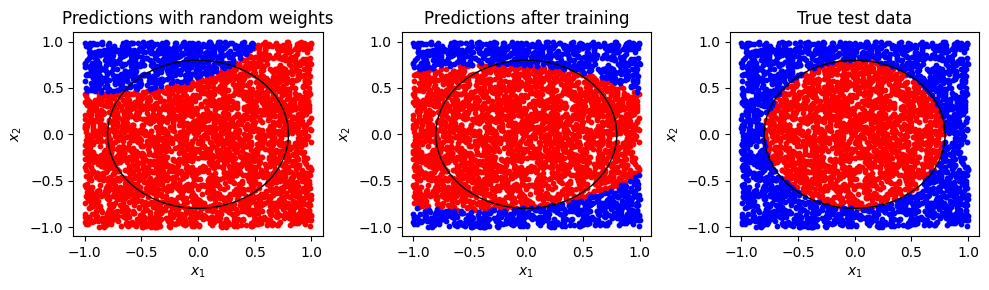

In [28]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: prameters = {}".format(i,params[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0])
plot_data(test_data, predicted_test, fig, axes[1])
plot_data(test_data, y_test, fig, axes[2])

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

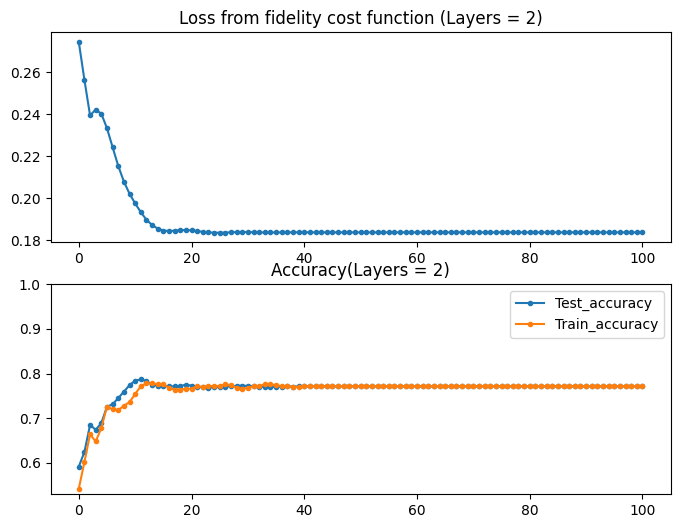

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

In [ ]:
# the numbers of training and test data
num_class = 2
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train = Circle(num_training)
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test = Circle(num_test)
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 2
learning_rate = 0.1
epochs = 50
batch_size = 128
#eta = 0.01

# Using the Optimizer
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
thetas = np.random.uniform(size=(num_layers, 3), requires_grad=True)
weights = np.random.uniform(size=(num_layers, 3), requires_grad=True)
alphas = np.random.uniform(size= num_class , requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, fidel_train = model_running_compressed(thetas, weights, train_data, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, fidel_test = model_running_compressed(thetas, weights, test_data, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = cost_wfc(thetas, weights, alphas, test_data, y_test, state_labels)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        thetas, weights, alphas, _, _, _ = opt.step(cost_wfc, thetas, weights, alphas, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = model_running_compressed(thetas, weights, train_data, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost_wfc(thetas, weights, alphas, train_data, y_train, state_labels)

    predicted_test, fidel_test = model_running_compressed(thetas, weights, test_data, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: thetas = {}, weights = {}".format(i, thetas[i], weights[i]))

print("Class weight aplphas = {}".format(alphas))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0])
plot_data(test_data, predicted_test, fig, axes[1])
plot_data(test_data, y_test, fig, axes[2])

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train accuracy')
axes[1].set_ylim(top = 1.0)
axes[1].legend()
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()